---
## 6. 탄소중립 시나리오 작성

#### 6-0. 라이브러리 호출

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#### 6-1. 이산화탄소 배출량 데이터 호출 및 시각화

In [2]:
# 탄소배출이 많은 10개 국가와, 탄소 중립을 목표로하는 국가 수집 (23개 국가)
co2_emissions = pd.read_csv('./DB/co2_emissions.csv', index_col='year')

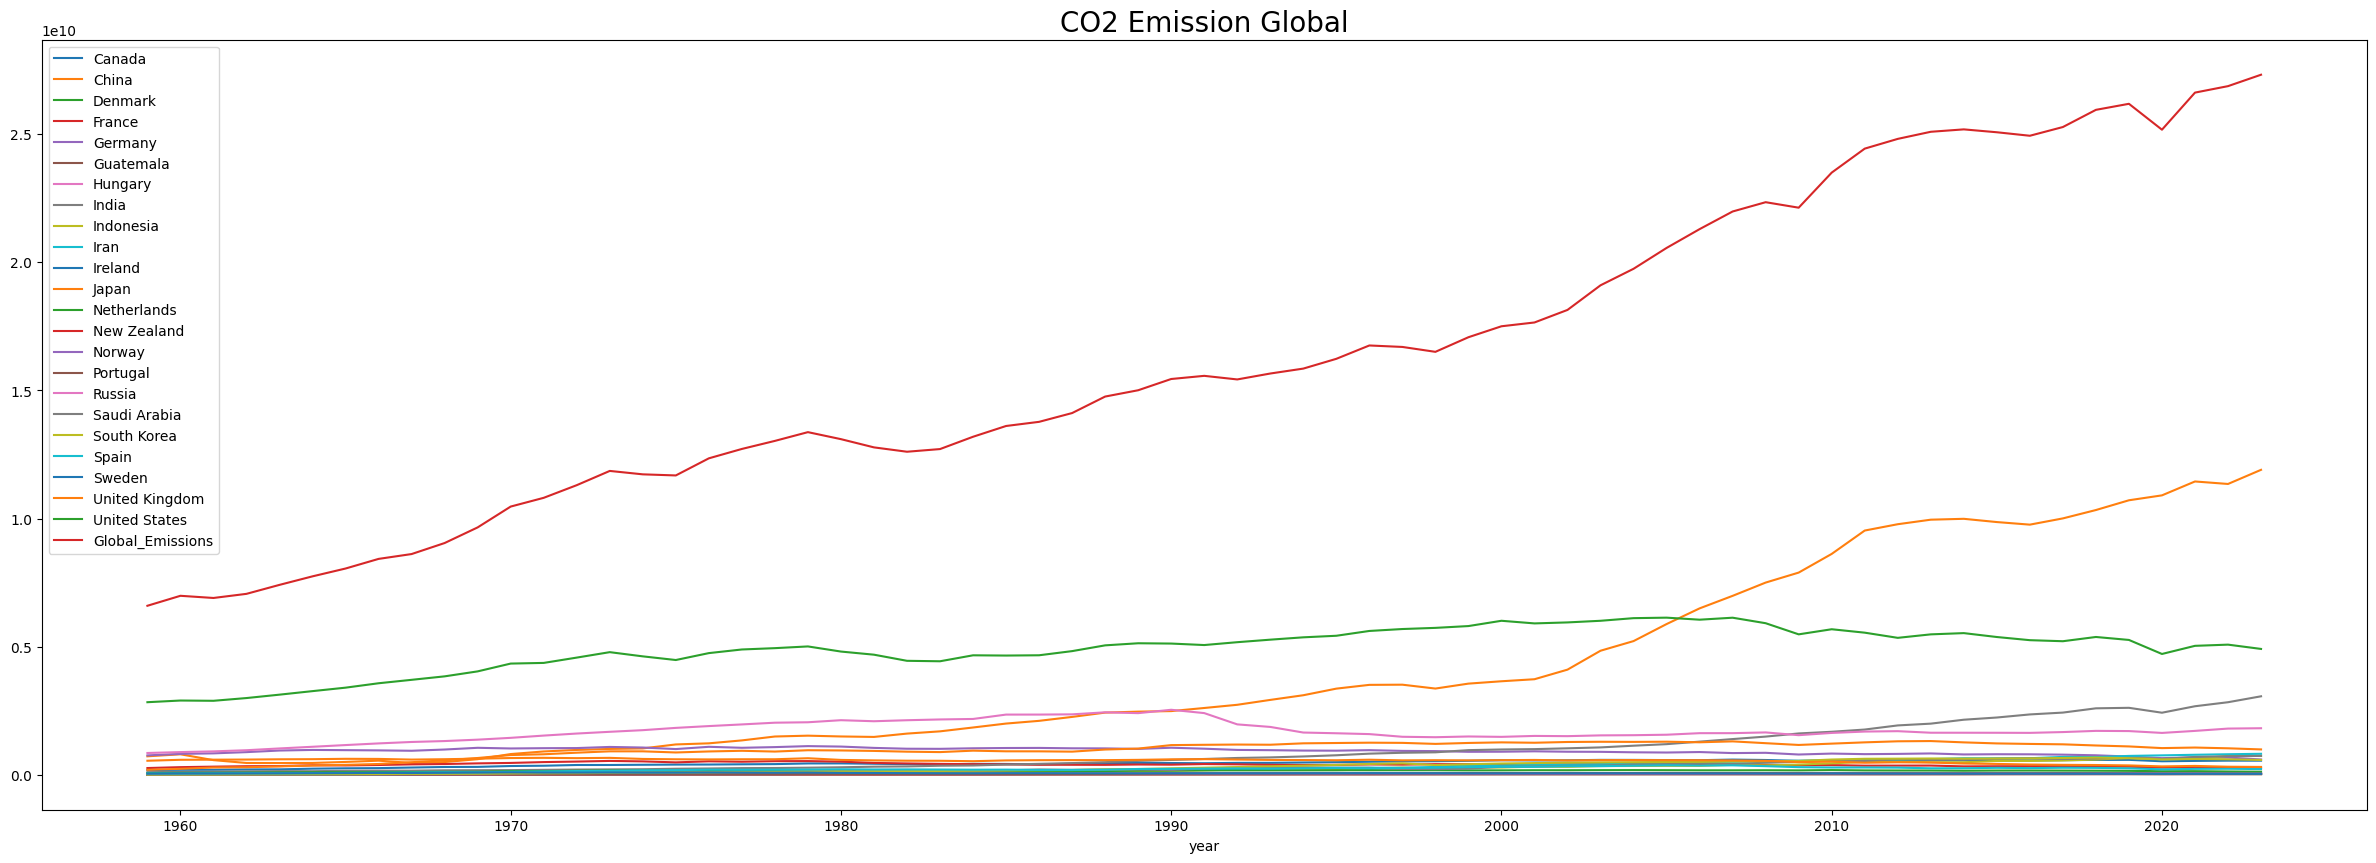

In [3]:
# 탄소배출 시각화
co2_emissions.plot(figsize=(30,10))
plt.title('CO2 Emission Global', fontsize=20)
plt.show()

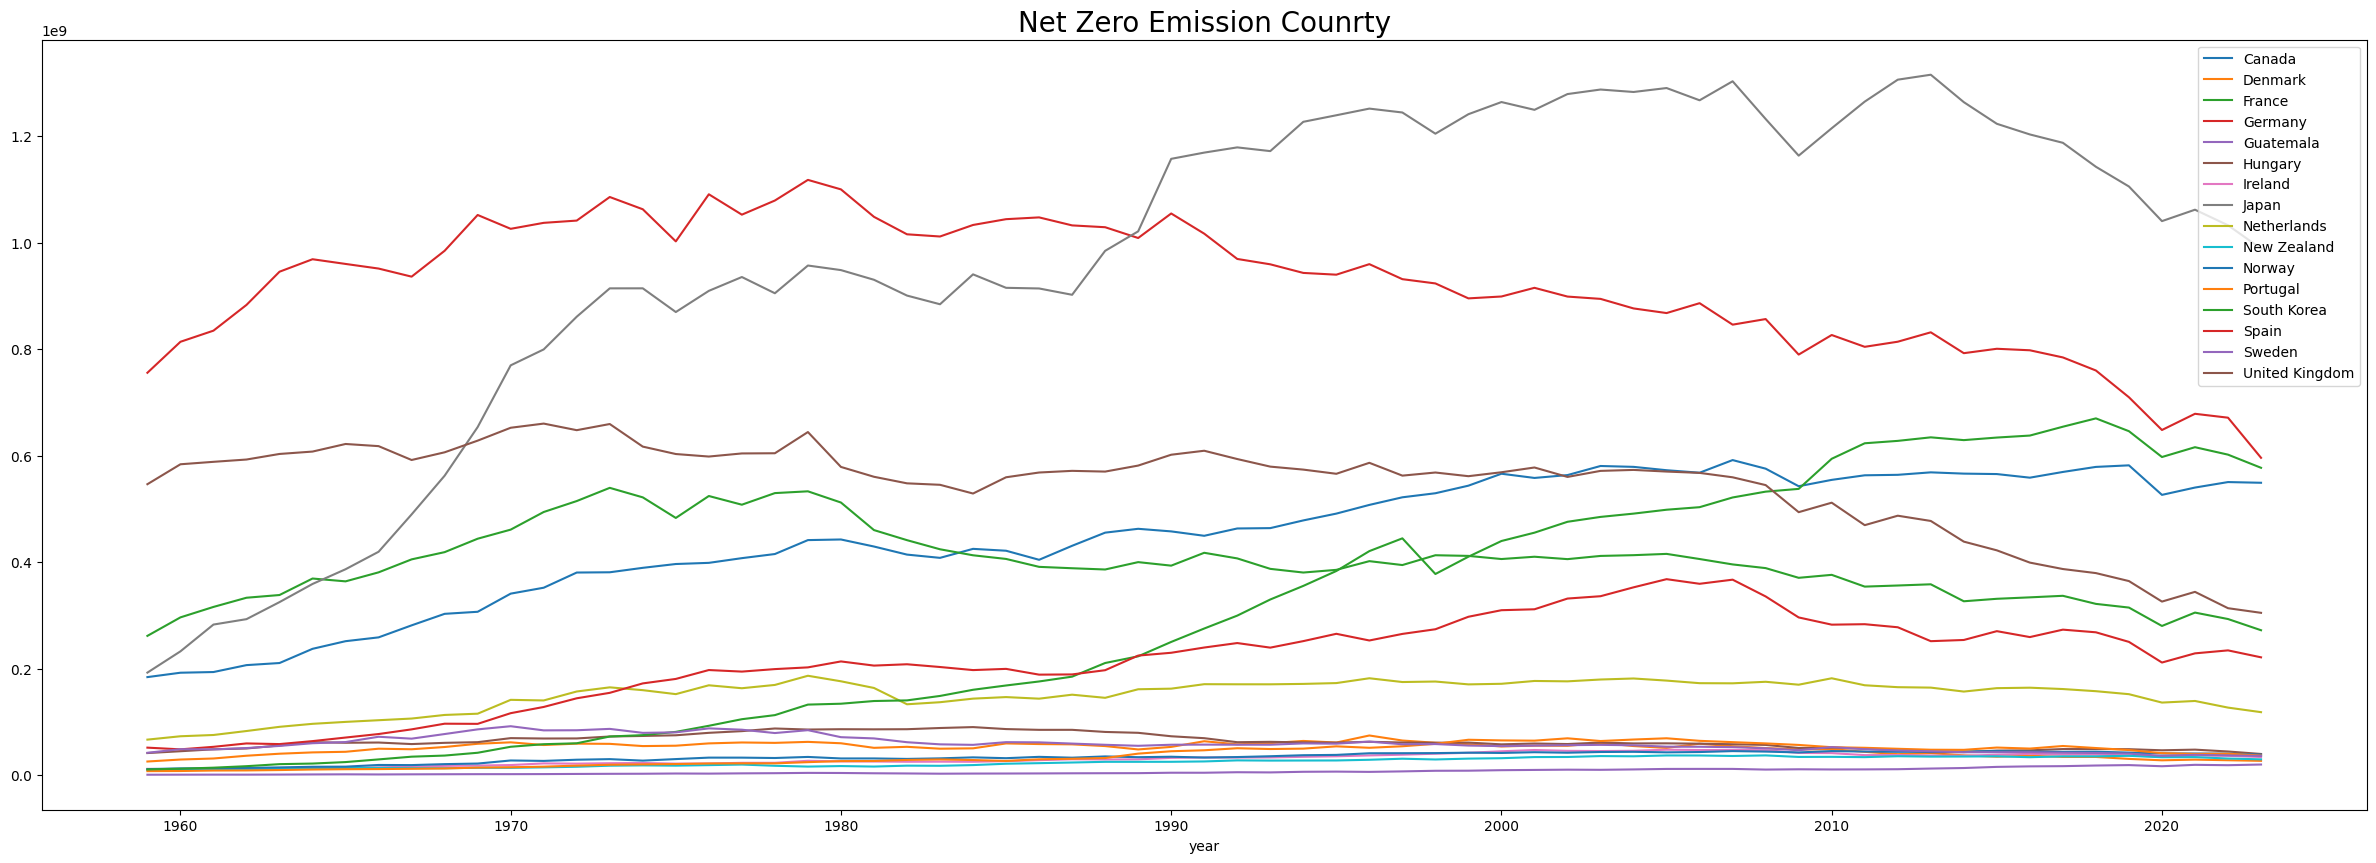

In [4]:
# 탄소 중립 선언 국가 CO2 배출량 시각화
co2_emissions_zero = co2_emissions.drop(['Global_Emissions', 'China', 'United States', 'India', 'Russia', 'Iran', 'Saudi Arabia', 'Indonesia'], axis=1)
co2_emissions_zero.plot(figsize=(30,10))
plt.title('Net Zero Emission Counrty', fontsize=20)
plt.show()

#### 6-2. 탄소 중립 시나리오

In [5]:
# 선형 회귀를 통한 예측

def linear_regression(dataframe, country):
    # 학습 데이터
    X = dataframe['x'].values.reshape(-1, 1)
    y = dataframe[country]
    
    # 훈련
    model = LinearRegression()
    model.fit(X,y)

    futures = np.arange(2024, 2051).reshape(-1, 1)
    prediction = model.predict(futures)

    return pd.Series(prediction, index=futures.flatten())


def create_forecast_df(dataframe, countries):
    # 결과를 저장할 빈 DataFrame 생성
    results_df = pd.DataFrame(index=range(2024, 2051))
    
    for country in countries:
        # 선형 회귀 예측
        linear_pred = linear_regression(dataframe, country)
        
        # 결과 DataFrame에 추가
        results_df[f'{country}'] = linear_pred
        # results_df[f'{country}_Prophet'] = prophet_pred
    
    # 소수점 반올림
    results_df = results_df.round(0)
    
    return results_df

#### **시나리오 1.** 탄소중립 선언 국가 목표 달성

In [6]:
co2_emissions = pd.read_csv('./DB/co2_emissions.csv', index_col='year')

# 탄소중립 안하는 국가
co2_not_zero = co2_emissions[['China', 'United States', 'India', 'Russia', 'Iran', 'Saudi Arabia', 'Indonesia']]
# 탄소중립 하는 국가
co2_yes_zero = co2_emissions.drop(['Global_Emissions', 'China', 'United States', 'India', 'Russia', 'Iran', 'Saudi Arabia', 'Indonesia'], axis=1)

In [7]:
# train 데이터 정의 (x: 날짜, y: 배출량)
co2_not_zero.loc[:, "x"] = co2_not_zero.index
co2_yes_zero.loc[:, "x"] = co2_yes_zero.index

/var/folders/9t/h4zy8ldj6wlfrqx_cclmr1nc0000gn/T/ipykernel_44987/3731333637.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  co2_not_zero.loc[:, "x"] = co2_not_zero.index


In [8]:
# 탄소중립 비선언 국가 배출량 예측 (2024~2050)
not_zero_list = ['China', 'United States', 'India', 'Russia', 'Iran', 'Saudi Arabia', 'Indonesia']
no_zero_pred = create_forecast_df(co2_not_zero, not_zero_list)

In [9]:
# 탄소중립 선언 국가 배출량 예측 (2024~2050)
zero_emissions = pd.Series(0, index=co2_yes_zero.columns)

temp_co2_zero = co2_emissions_zero.copy()
temp_co2_zero.loc[2050] = zero_emissions

new_index = pd.Index(range(1959, 2051))
yes_zero_pred = temp_co2_zero.reindex(new_index).interpolate(method='linear')
yes_zero_pred = yes_zero_pred[yes_zero_pred.index >= 2024]

In [10]:
no_zero_combined_results = pd.concat([co2_not_zero, no_zero_pred]).drop(['x'], axis=1)
yes_zero_combined_results = pd.concat([co2_yes_zero, yes_zero_pred]).drop(['x'], axis=1)
combined_results = pd.concat([no_zero_combined_results, yes_zero_combined_results], axis=1)

global_co2_emissions = combined_results.sum(axis=1)
combined_results['Global_Emissions'] = global_co2_emissions

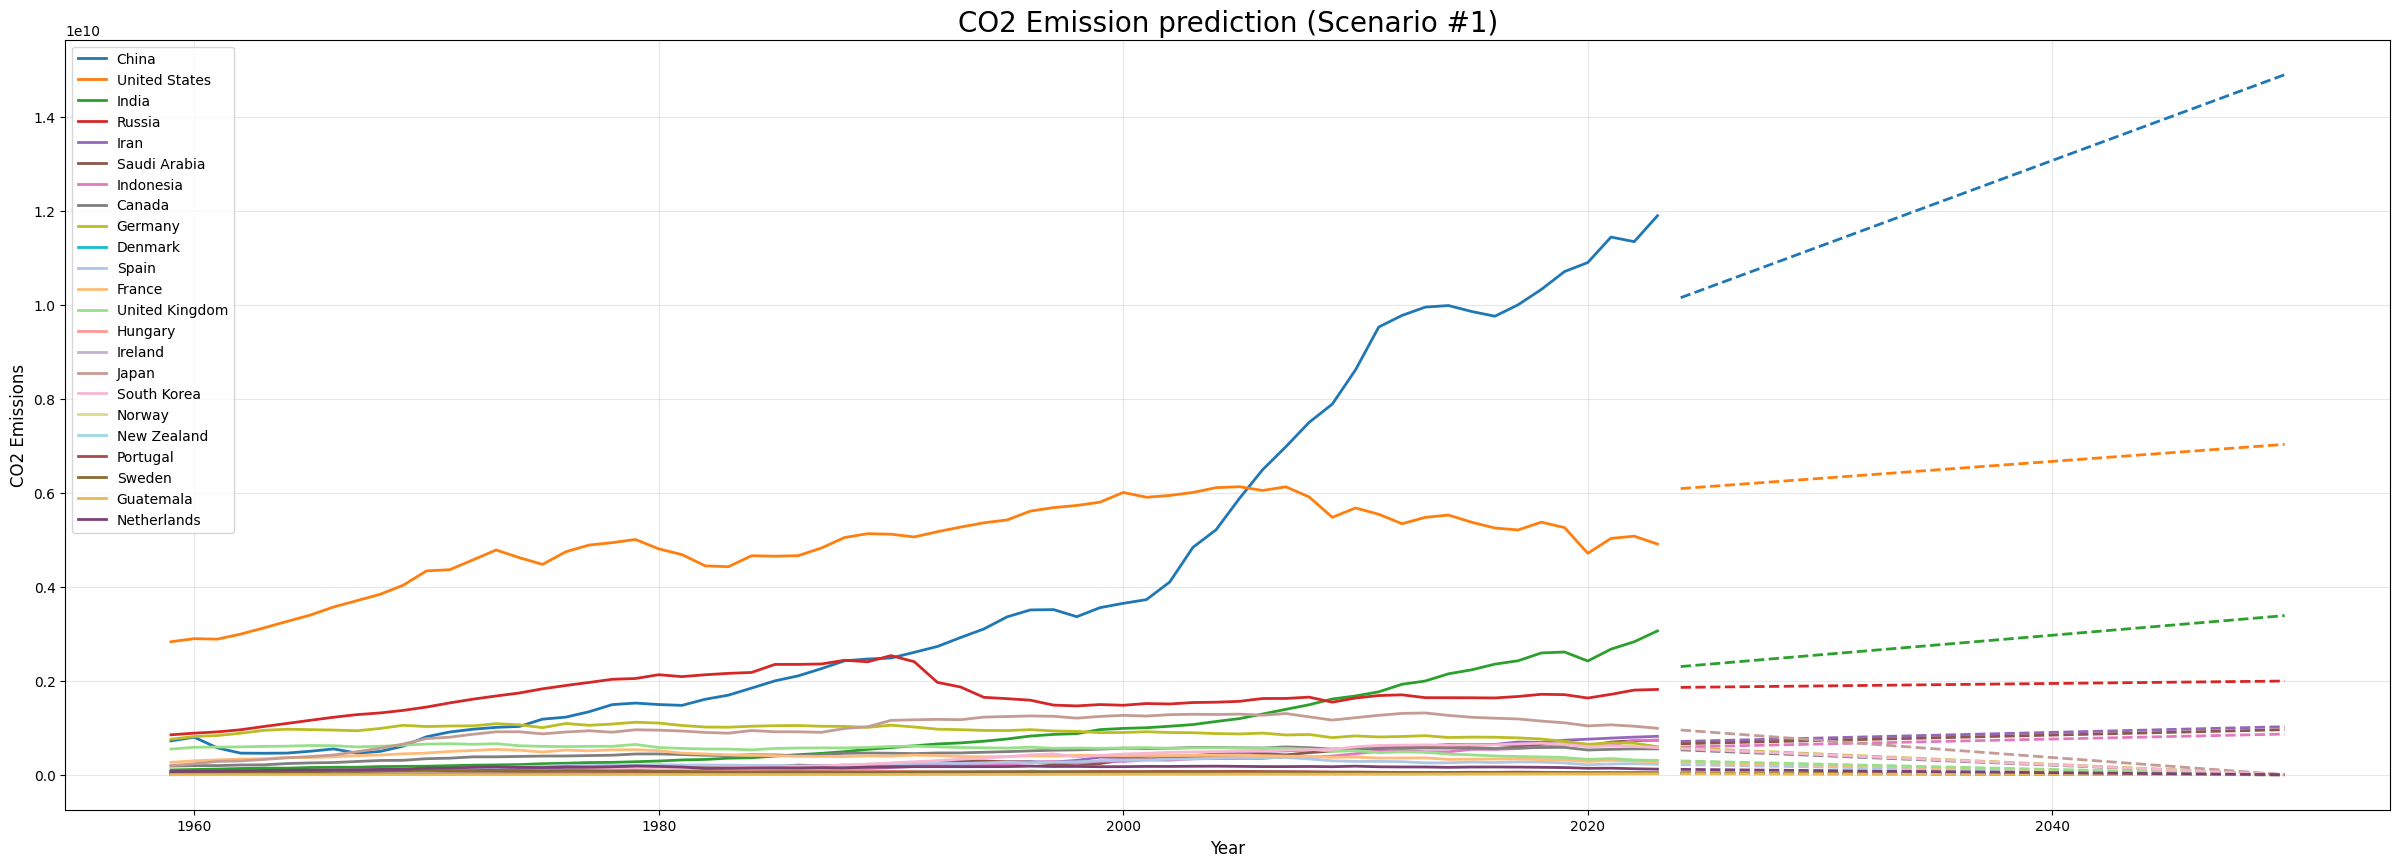

In [11]:
# 그래프 크기 설정
plt.figure(figsize=(30,10))

# 국가별 색상 매핑 정의
countries_colors = {
    'China': '#1f77b4',
    'United States': '#ff7f0e',
    'India': '#2ca02c',
    'Russia': '#d62728',
    'Iran': '#9467bd',
    'Saudi Arabia': '#8c564b',
    'Indonesia': '#e377c2',
    'Canada': '#7f7f7f',
    'Germany': '#bcbd22',
    'Denmark': '#17becf',
    'Spain': '#aec7e8',
    'France': '#ffbb78',
    'United Kingdom': '#98df8a',
    'Hungary': '#ff9896',
    'Ireland': '#c5b0d5',
    'Japan': '#c49c94',
    'South Korea': '#f7b6d2',
    'Norway': '#dbdb8d',
    'New Zealand': '#9edae5',
    'Portugal': '#ad494a',
    'Sweden': '#8c6d31',
    'Guatemala': '#e7ba52',
    'Netherlands': '#7b4173',
}

# 한번에 모든 국가 데이터 플로팅
for country, color in countries_colors.items():
    # 과거 데이터 플로팅 (실선)
    plt.plot(combined_results.index[:65], combined_results[:65][country], 
             color=color, 
             label=f'{country}',
             linewidth=2)
    
    # 예측 데이터 플로팅 (점선)
    plt.plot(combined_results.index[65:], combined_results[65:][country], 
             color=color, 
             linestyle='--',
             linewidth=2)

plt.grid(True, alpha=0.3)
plt.xlabel('Year', fontsize=12)
plt.ylabel('CO2 Emissions', fontsize=12)
plt.title('CO2 Emission prediction (Scenario #1)', fontsize=20)
plt.legend()

plt.show()

In [12]:
# combined_results.to_csv('./DB/2024-2050_co2_emission.csv')

#### **시나리오 2** 탄소중립 실패

In [13]:
co2_emissions = pd.read_csv('./DB/co2_emissions.csv', index_col='year')
# 탄소중립 실패 DataFrame 정의
co2_fail = co2_emissions.copy().drop(['Global_Emissions'], axis=1)
co2_fail.loc[:, "x"] = co2_fail.index

In [14]:
not_zero_list = [
    'China', 
    'United States', 
    'India', 
    'Russia', 
    'Iran', 
    'Saudi Arabia', 
    'Indonesia', 
    'Canada', 
    'Germany', 
    'Denmark', 
    'Spain', 
    'France', 
    'United Kingdom', 
    'Hungary', 
    'Ireland', 
    'Japan', 
    'South Korea', 
    'Norway', 
    'New Zealand', 
    'Portugal', 
    'Sweden', 
    'Guatemala', 
    'Netherlands'
]
no_zero_pred = create_forecast_df(co2_fail, not_zero_list)

In [15]:
combined_results = pd.concat([co2_fail, no_zero_pred]).drop(['x'], axis=1)

global_co2_emissions = combined_results.sum(axis=1)
combined_results['Global_Emissions'] = global_co2_emissions

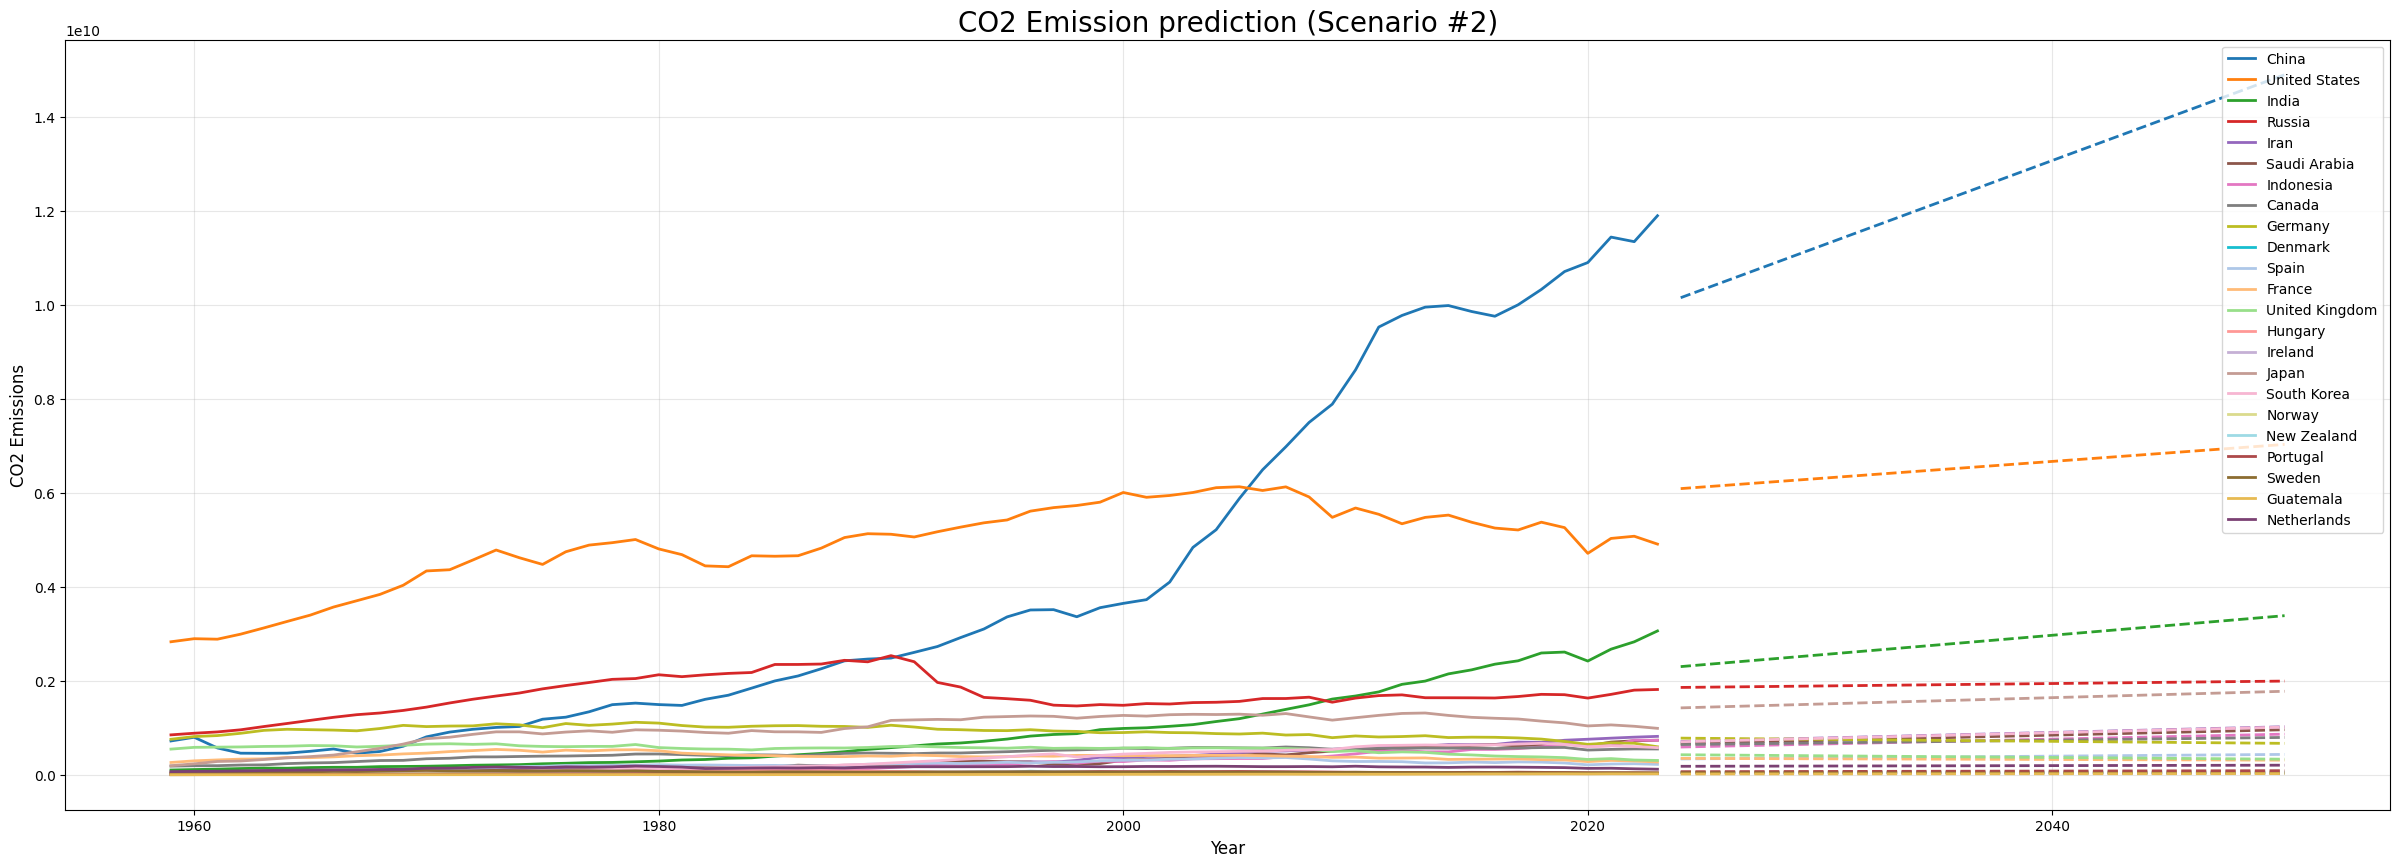

In [16]:
# 그래프 크기 설정
plt.figure(figsize=(30,10))

# 국가별 색상 매핑 정의
countries_colors = {
    'China': '#1f77b4',
    'United States': '#ff7f0e',
    'India': '#2ca02c',
    'Russia': '#d62728',
    'Iran': '#9467bd',
    'Saudi Arabia': '#8c564b',
    'Indonesia': '#e377c2',
    'Canada': '#7f7f7f',
    'Germany': '#bcbd22',
    'Denmark': '#17becf',
    'Spain': '#aec7e8',
    'France': '#ffbb78',
    'United Kingdom': '#98df8a',
    'Hungary': '#ff9896',
    'Ireland': '#c5b0d5',
    'Japan': '#c49c94',
    'South Korea': '#f7b6d2',
    'Norway': '#dbdb8d',
    'New Zealand': '#9edae5',
    'Portugal': '#ad494a',
    'Sweden': '#8c6d31',
    'Guatemala': '#e7ba52',
    'Netherlands': '#7b4173',
}

# 한번에 모든 국가 데이터 플로팅
for country, color in countries_colors.items():
    # 과거 데이터 플로팅 (실선)
    plt.plot(combined_results.index[:65], combined_results[:65][country], 
             color=color, 
             label=f'{country}',
             linewidth=2)
    
    # 예측 데이터 플로팅 (점선)
    plt.plot(combined_results.index[65:], combined_results[65:][country], 
             color=color, 
             linestyle='--',
             linewidth=2)

plt.grid(True, alpha=0.3)
plt.xlabel('Year', fontsize=12)
plt.ylabel('CO2 Emissions', fontsize=12)
plt.title('CO2 Emission prediction (Scenario #2)', fontsize=20)
plt.legend(loc='upper right')

plt.show()

In [17]:
# combined_results.to_csv('./DB/2024-2050_co2_emission_fail_version.csv')

#### **시나리오 3** 모든 국가 탄소중립 달성

In [18]:
co2_emissions = pd.read_csv('./DB/co2_emissions.csv', index_col='year')

co2_zero_success = co2_emissions.copy().drop(['Global_Emissions'], axis=1)
co2_zero_success.loc[:, "x"] = co2_zero_success.index

In [19]:
zero_emissions = pd.Series(0, index=co2_zero_success.columns)

temp_co2_zero = co2_zero_success.copy()
temp_co2_zero.loc[2050] = zero_emissions

new_index = pd.Index(range(1959, 2051))
yes_zero_pred = temp_co2_zero.reindex(new_index).interpolate(method='linear')
yes_zero_pred = yes_zero_pred[yes_zero_pred.index >= 2024]

In [20]:
combined_results = pd.concat([co2_zero_success, yes_zero_pred]).drop(['x'], axis=1)
global_co2_emissions = combined_results.sum(axis=1)
combined_results['Global_Emissions'] = global_co2_emissions

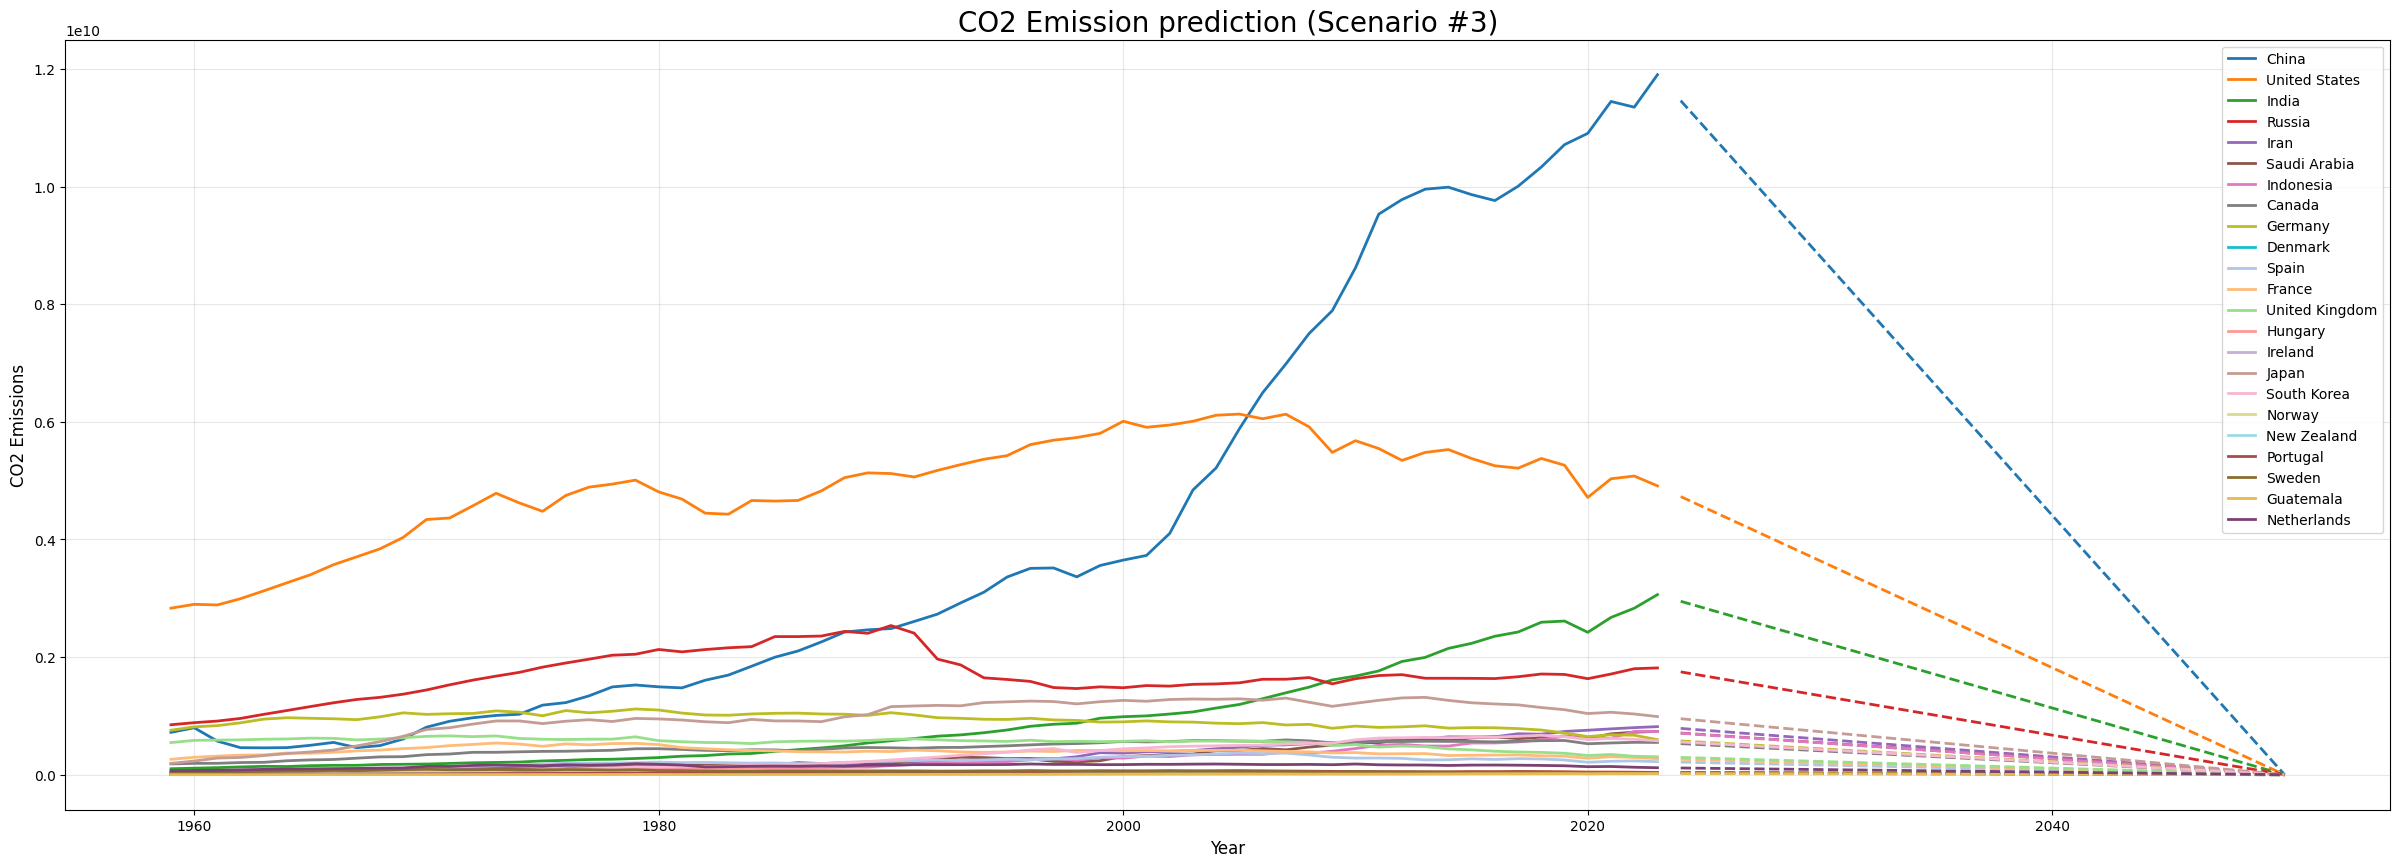

In [21]:
# 그래프 크기 설정
plt.figure(figsize=(30,10))

# 국가별 색상 매핑 정의
countries_colors = {
    # 'Global_Emissions': '#000000',
    'China': '#1f77b4',
    'United States': '#ff7f0e',
    'India': '#2ca02c',
    'Russia': '#d62728',
    'Iran': '#9467bd',
    'Saudi Arabia': '#8c564b',
    'Indonesia': '#e377c2',
    'Canada': '#7f7f7f',
    'Germany': '#bcbd22',
    'Denmark': '#17becf',
    'Spain': '#aec7e8',
    'France': '#ffbb78',
    'United Kingdom': '#98df8a',
    'Hungary': '#ff9896',
    'Ireland': '#c5b0d5',
    'Japan': '#c49c94',
    'South Korea': '#f7b6d2',
    'Norway': '#dbdb8d',
    'New Zealand': '#9edae5',
    'Portugal': '#ad494a',
    'Sweden': '#8c6d31',
    'Guatemala': '#e7ba52',
    'Netherlands': '#7b4173',
}

# 한번에 모든 국가 데이터 플로팅
for country, color in countries_colors.items():
    # 과거 데이터 플로팅 (실선)
    plt.plot(combined_results.index[:65], combined_results[:65][country], 
             color=color, 
             label=f'{country}',
             linewidth=2)
    
    # 예측 데이터 플로팅 (점선)
    plt.plot(combined_results.index[65:], combined_results[65:][country], 
             color=color, 
             linestyle='--',
             linewidth=2)

plt.grid(True, alpha=0.3)
plt.xlabel('Year', fontsize=12)
plt.ylabel('CO2 Emissions', fontsize=12)
plt.title('CO2 Emission prediction (Scenario #3)', fontsize=20)
plt.legend()

plt.show()

In [22]:
# combined_results.to_csv('./DB/2024-2050_co2_emission_success_version.csv')